# Installing the necessary libraries

In [1]:
# Install python pacakges
!pip install -q PubChemPy==1.0.4             # Install PubChemPy library for accessing PubChem data
!pip install -q rdkit-pypi==2022.09.5        # Install rdkit-pypi package, a version of the RDKit cheminformatics toolkit
!pip install -q scikit-optimize==0.10.1      # Install scikit-optimize library for optimization in machine learning
!pip install scikit-learn==1.1.3



  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 22.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.30.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.1.3 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, bu

In [2]:
import pandas as pd                            # Data manipulation and analysis library
import numpy as np                             # Numerical operations library
np.int = np.int32                              # To slove the error about AttributeError: module 'numpy' has no attribute 'int'  # Set default integer type to int32
np.float = np.float64                          # Set default float type to float64
import seaborn as sns                          # Statistical data visualization library
import pubchempy as pcp                        # PubChem API for accessing chemical information
from pubchempy import get_compounds, Compound  # Functions for working with PubChem data
from collections import Counter                # Container for counting hashable objects

# Molecular Descriptors Calculation
from rdkit import Chem                                 # Toolkit for cheminformatics
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, DataStructs  # Molecular descriptors and fingerprint generation
from rdkit.DataStructs import ExplicitBitVect          # Data structures for working with molecular descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors   # Calculation of molecular descriptors

# Modeling
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold   # Model selection and evaluation tools
from sklearn import metrics                           # Metrics for evaluating model performance
from sklearn.preprocessing import MinMaxScaler        # Feature scaling for RDKit descriptors
from pandas.core.common import random_state           # Setting random state for reproducibility
from sklearn.neighbors import KNeighborsRegressor     # K-Nearest Neighbors regression algorithm development
from sklearn.ensemble import RandomForestRegressor    # Random Forest regression algorithm development
from sklearn.svm import SVR                           # Support Vector Regression algorithm development
from sklearn.metrics import mean_squared_error, r2_score, make_scorer   # Metrics for evaluating regression model performance

# Visualization
import matplotlib.pyplot as plt   # Plotting library
# Setting matplotlib to display plots inline in Jupyter notebooks
%matplotlib inline


# import the data set

In [3]:
from google.colab import files
upload = files.upload()

Saving ECFP6_descrs.csv to ECFP6_descrs.csv


In [4]:
from google.colab import files
upload = files.upload()

Saving FCFP6_descrs.csv to FCFP6_descrs.csv


In [5]:
from google.colab import files
upload = files.upload()

Saving MACCS_descrs.csv to MACCS_descrs.csv


In [6]:
from google.colab import files
upload = files.upload()

Saving medDog.csv to medDog.csv


In [7]:
from google.colab import files
upload = files.upload()

Saving rdkit_descrs.csv to rdkit_descrs.csv


In [8]:
from google.colab import files
upload = files.upload()

Saving X_rdkit_descrs_scal.csv to X_rdkit_descrs_scal.csv


In [9]:
df = pd.read_csv('medDog.csv')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CAS        179 non-null    object 
 1   LambdaZHl  179 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.9+ KB


# Extracting SMILES codes from PubChem database

In [ ]:
'''
This script enables automatically connecting to the PubChem database,
Transfer of CAS numbers which are converted to CID identifiers
as first step and then resolved to respective SMILES codes.

'''

def cas_to_cid (df):

  df['PubChemCID'] = None
  # Searching PubChem for CID
  for i, CAS in df['CAS'].items():
    try:
        # Searching PubChem for CID using CAS number
        results = get_compounds(CAS, 'name')
        if results:
            cid = results[0].cid
            df.at[i, 'PubChemCID'] = cid
        else:
            print(f"No results found for CAS number {CAS}")

    except Exception as e:
        pass # silent the error message; otherwise it will print a lot error message: server is busy

  # Check PubChemCID; If CID is None, run the "While loop" and request PubChem server again to get all Cid
  while df['PubChemCID'].isnull().sum() > 0:
    print (df['PubChemCID'].isnull().sum())
    for i, CAS in df[df['PubChemCID'].isnull()]['CAS'].items():
      try:
        # Searching PubChem for CID using CAS number
        results = get_compounds(CAS, 'name')
        if results:
            cid = results[0].cid
            df.at[i, 'PubChemCID'] = cid
        else:
            print(f"No results found for CAS number {CAS}")
      except Exception as e:
        pass

  return df

# Function for searching and extracting SMILES code with entering CID
def cid_to_smiles (data):
  data['SMILES'] = None

  for i, cid in data['PubChemCID'].items():
    try:
      compound = pcp.Compound.from_cid(cid)
      if compound:
        smiles = compound.canonical_smiles
        data.at[i, 'SMILES'] = smiles
      else:
        print(f'No results found for PubChemCID {cid}')

    except Exception as e:
        pass # silent the error message; otherwise it will print a lot error message: "PUG-REST server is busy"

  # Check SMILES; If SMILES is None, run the "While loop" and request PubChem server again to get all SMILES
  while data['SMILES'].isnull().sum() > 0:
    print (data['SMILES'].isnull().sum())
    for i, cid in data[data['SMILES'].isnull()]['PubChemCID'].items():
     try:
       compound = pcp.Compound.from_cid(cid)
       if compound:
        smiles = compound.canonical_smiles
        data.at[i, 'SMILES'] = smiles
       else:
        print(f'No results found for PubChemCID {cid}')
     except Exception as e:
       pass

  return data

In [ ]:
# Define a function that transform SMILES string into RDKIT descriptors
def cal_rdkit_descr(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    mol_descriptors = []
    for mol in mols:
        mol = Chem.AddHs(mol)
        descriptors = calc.CalcDescriptors(mol)
        mol_descriptors.append(descriptors)

    return pd.DataFrame(mol_descriptors, index = smiles, columns=desc_names)


# Define a funciton that transform a SMILES string into an FCFP (if use_features = TRUE) or--
# --the Extended-Connectivity Fingerprints (ECFP) descriptors (if use_features = FALSE)

def cal_ECFP6_descr (smiles,
            R = 3,
            nBits = 2**10, # nBits = 1024
            use_features = False,
            use_chirality = False):

   '''
   Inputs:
   - smiles...SMILES string of input compounds
   - R....Maximum radius of circular substructures--By using this radius parameter, we compute ECFP6 (the equivalent of radius 3)
   - nBits....number of bits, default is 2048. 1024 is also widely used.
   - use_features...if true then use pharmacophoric atom features (FCFPs), if false then use stadnard DAYLIGHT atom features (ECFP)
   - use_chirality...if true then append tetrahedral chirality flags to atom features
   Outputs:
   - pd.DataFrame...ECFP or FCFPs with length nBits and maximum radus R

   '''
   mols = [AllChem.MolFromSmiles(i) for i in smiles]

   ecfp_descriptors = []
   for mol in mols:
        ecfp = AllChem.GetMorganFingerprintAsBitVect(mol,
                                radius = R,
                                nBits = nBits,
                                useFeatures = use_features,
                                useChirality = use_chirality)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(ecfp, array)
        ecfp_descriptors.append(ecfp)

   return pd.DataFrame([list(l) for l in ecfp_descriptors], index = smiles, columns=[f'ECFP6_Bit_{i}' for i in range(nBits)])


# Define a funciton that transform a SMILES string into an FCFP (if use_features = TRUE)
def cal_FCFP6_descr(smiles,
            R = 3,
            nBits = 2**10, # nBits = 1024
            use_features = True,
            use_chirality = False):

   mols = [AllChem.MolFromSmiles(i) for i in smiles]

   fcfp_descriptors = []
   for mol in mols:
        fcfp = AllChem.GetMorganFingerprintAsBitVect(mol,
                                radius = R,
                                nBits = nBits,
                                useFeatures = use_features,
                                useChirality = use_chirality)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fcfp, array)
        fcfp_descriptors.append(fcfp)

   return pd.DataFrame([list(l) for l in fcfp_descriptors], index = smiles, columns=[f'FCFP6_Bit_{i}' for i in range(nBits)])


# Define a funciton that transform a SMILES string into an MACCS fingerprints

def cal_MACCS_descr (smiles):

   mols = [Chem.MolFromSmiles(i) for i in smiles]
   MACCS_descriptors = []
   for mol in mols:
        fp = MACCSkeys.GenMACCSKeys (mol)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, array)
        MACCS_descriptors.append(fp)

   return pd.DataFrame([list(l) for l in MACCS_descriptors], index = smiles, columns=[f'MACCS_Bit_{i}' for i in range(167)])

In [ ]:
df_with_cids = cas_to_cid(df)
df_with_smiles = cid_to_smiles(df_with_cids)

In [ ]:
# Calculating RDKit descriptors
rdkit_descrs = cal_rdkit_descr(df['SMILES']).drop(['BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW'],axis=1)
rdkit_descrs.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
SMILES,,,,,,,,,,,,,,,,,,,,,
CC(C)C(C(=O)NC(CC1=CC=C(C=C1)O)C(=O)O)NC(=O)C(CC(=O)O)NC(=O)C(CCCCN)NC(=O)C(CCCN=C(N)N)N,15.369928,-6.372005,15.369928,0.975631,0.034621,679.776,630.384,679.365324,268,0,...,0,0,0,0,0,0,0,0,0,0
C1=CC(=C(C=C1CC(C(=O)O)OC(=O)C=CC2=C(C(=C(C=C2)O)O)C=CC3=CC(=C(C=C3)O)O)O)O,13.470407,-4.324334,13.470407,0.943689,0.105982,494.452,472.276,494.121297,186,0,...,0,0,0,0,0,0,0,0,0,0
COC1=C(C=C2C(=C1O)C(=O)C=C(O2)C3=CC=CC=C3)OC4C(C(C(C(O4)C(=O)O)O)O)O,13.637567,-4.432959,13.637567,0.912260,0.357108,460.391,440.231,460.100561,174,0,...,0,0,0,0,0,0,0,0,0,0
CCCC(=O)OCOC(=O)C1=C(NC(=C(C1C2=C(C(=CC=C2)Cl)Cl)C(=O)OC)C)C,13.964906,-4.447231,13.964906,0.690309,0.484773,456.322,433.138,455.090243,162,0,...,0,0,0,0,0,0,0,0,0,0
CS(=O)(=O)[O-].CS(=O)(=O)[O-].C1=C[N+](=CC=C1C=NO)C[N+]2=CC=C(C=C2)C=NO,9.534722,-5.090278,9.534722,0.132186,0.189813,448.479,428.319,448.072256,160,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ECFP6_descrs = cal_ECFP6_descr(smiles=df['SMILES'])
ECFP6_descrs.head()

,ECFP6_Bit_0,ECFP6_Bit_1,ECFP6_Bit_2,ECFP6_Bit_3,ECFP6_Bit_4,ECFP6_Bit_5,ECFP6_Bit_6,ECFP6_Bit_7,ECFP6_Bit_8,ECFP6_Bit_9,...,ECFP6_Bit_1014,ECFP6_Bit_1015,ECFP6_Bit_1016,ECFP6_Bit_1017,ECFP6_Bit_1018,ECFP6_Bit_1019,ECFP6_Bit_1020,ECFP6_Bit_1021,ECFP6_Bit_1022,ECFP6_Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
CC(C)C(C(=O)NC(CC1=CC=C(C=C1)O)C(=O)O)NC(=O)C(CC(=O)O)NC(=O)C(CCCCN)NC(=O)C(CCCN=C(N)N)N,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
C1=CC(=C(C=C1CC(C(=O)O)OC(=O)C=CC2=C(C(=C(C=C2)O)O)C=CC3=CC(=C(C=C3)O)O)O)O,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
COC1=C(C=C2C(=C1O)C(=O)C=C(O2)C3=CC=CC=C3)OC4C(C(C(C(O4)C(=O)O)O)O)O,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
CCCC(=O)OCOC(=O)C1=C(NC(=C(C1C2=C(C(=CC=C2)Cl)Cl)C(=O)OC)C)C,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
CS(=O)(=O)[O-].CS(=O)(=O)[O-].C1=C[N+](=CC=C1C=NO)C[N+]2=CC=C(C=C2)C=NO,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
FCFP6_descrs = cal_FCFP6_descr(df_with_smiles['SMILES'])
FCFP6_descrs.head()

,FCFP6_Bit_0,FCFP6_Bit_1,FCFP6_Bit_2,FCFP6_Bit_3,FCFP6_Bit_4,FCFP6_Bit_5,FCFP6_Bit_6,FCFP6_Bit_7,FCFP6_Bit_8,FCFP6_Bit_9,...,FCFP6_Bit_1014,FCFP6_Bit_1015,FCFP6_Bit_1016,FCFP6_Bit_1017,FCFP6_Bit_1018,FCFP6_Bit_1019,FCFP6_Bit_1020,FCFP6_Bit_1021,FCFP6_Bit_1022,FCFP6_Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
CC(C)C(C(=O)NC(CC1=CC=C(C=C1)O)C(=O)O)NC(=O)C(CC(=O)O)NC(=O)C(CCCCN)NC(=O)C(CCCN=C(N)N)N,1,1,1,1,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
C1=CC(=C(C=C1CC(C(=O)O)OC(=O)C=CC2=C(C(=C(C=C2)O)O)C=CC3=CC(=C(C=C3)O)O)O)O,1,1,1,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
COC1=C(C=C2C(=C1O)C(=O)C=C(O2)C3=CC=CC=C3)OC4C(C(C(C(O4)C(=O)O)O)O)O,1,1,1,1,1,0,1,1,0,0,...,0,0,0,1,0,0,1,0,0,0
CCCC(=O)OCOC(=O)C1=C(NC(=C(C1C2=C(C(=CC=C2)Cl)Cl)C(=O)OC)C)C,1,0,1,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
CS(=O)(=O)[O-].CS(=O)(=O)[O-].C1=C[N+](=CC=C1C=NO)C[N+]2=CC=C(C=C2)C=NO,1,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
MACCS_descrs = cal_MACCS_descr(smiles=df['SMILES'])
MACCS_descrs.head()

,MACCS_Bit_0,MACCS_Bit_1,MACCS_Bit_2,MACCS_Bit_3,MACCS_Bit_4,MACCS_Bit_5,MACCS_Bit_6,MACCS_Bit_7,MACCS_Bit_8,MACCS_Bit_9,...,MACCS_Bit_157,MACCS_Bit_158,MACCS_Bit_159,MACCS_Bit_160,MACCS_Bit_161,MACCS_Bit_162,MACCS_Bit_163,MACCS_Bit_164,MACCS_Bit_165,MACCS_Bit_166
SMILES,,,,,,,,,,,,,,,,,,,,,
CC(C)C(C(=O)NC(CC1=CC=C(C=C1)O)C(=O)O)NC(=O)C(CC(=O)O)NC(=O)C(CCCCN)NC(=O)C(CCCN=C(N)N)N,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
C1=CC(=C(C=C1CC(C(=O)O)OC(=O)C=CC2=C(C(=C(C=C2)O)O)C=CC3=CC(=C(C=C3)O)O)O)O,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,1,1,1,0
COC1=C(C=C2C(=C1O)C(=O)C=C(O2)C3=CC=CC=C3)OC4C(C(C(C(O4)C(=O)O)O)O)O,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0
CCCC(=O)OCOC(=O)C1=C(NC(=C(C1C2=C(C(=CC=C2)Cl)Cl)C(=O)OC)C)C,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
CS(=O)(=O)[O-].CS(=O)(=O)[O-].C1=C[N+](=CC=C1C=NO)C[N+]2=CC=C(C=C2)C=NO,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1


In [12]:
# Checking for missing values
# if the results > 0, it means there is a missing value or several missing values
df.isna().sum().max()

0

In [13]:
y = df['LambdaZHl']

In [ ]:
# Applying feature scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_rdkit_descrs = rdkit_descrs
X_rdkit_descrs_scal = scaler.fit_transform(X_rdkit_descrs)
X_rdkit_descrs_scal = pd.DataFrame(X_rdkit_descrs_scal, columns = rdkit_descrs.columns.values.tolist())
print(X_rdkit_descrs_scal)

NameError: name 'rdkit_descrs' is not defined

In [14]:
# No SMILES for correlation
ECFP6_descrs = pd.read_csv('ECFP6_descrs.csv')
FCFP6_descrs = pd.read_csv('FCFP6_descrs.csv')
MACCS_descrs = pd.read_csv('MACCS_descrs.csv')
X_rdkit_descrs_scal = pd.read_csv('X_rdkit_descrs_scal.csv')

In [15]:
X = pd.concat([
               X_rdkit_descrs_scal.reset_index(drop=True),
               ECFP6_descrs.reset_index(drop=True),
               FCFP6_descrs.reset_index(drop=True),
               MACCS_descrs.reset_index(drop=True)], axis=1)
display(X)

,rdkit_MaxEStateIndex,rdkit_MinEStateIndex,rdkit_MaxAbsEStateIndex,rdkit_MinAbsEStateIndex,rdkit_qed,rdkit_MolWt,rdkit_HeavyAtomMolWt,rdkit_ExactMolWt,rdkit_NumValenceElectrons,rdkit_NumRadicalElectrons,...,MACCS_Bit_157,MACCS_Bit_158,MACCS_Bit_159,MACCS_Bit_160,MACCS_Bit_161,MACCS_Bit_162,MACCS_Bit_163,MACCS_Bit_164,MACCS_Bit_165,MACCS_Bit_166
0,0.736889,0.258054,0.736889,0.193164,0.027381,0.166078,0.165591,0.166081,0.176230,0.0,...,1,1,1,1,1,1,1,1,1,0
1,0.645819,0.496482,0.645819,0.186839,0.105402,0.115762,0.119362,0.115755,0.120219,0.0,...,1,0,1,0,0,1,1,1,1,0
2,0.653833,0.483833,0.653833,0.180617,0.379963,0.106514,0.109992,0.106513,0.112022,0.0,...,1,0,1,1,0,1,1,1,1,0
3,0.669527,0.482172,0.669527,0.136673,0.519541,0.105410,0.107918,0.105151,0.103825,0.0,...,1,1,1,1,1,1,1,1,1,0
4,0.457129,0.407296,0.457129,0.026171,0.197056,0.103280,0.106509,0.103245,0.102459,0.0,...,0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,0.775205,0.063732,0.775205,0.393626,0.312274,0.180809,0.174971,0.180794,0.196721,0.0,...,1,1,1,1,1,0,1,1,1,0
175,0.708081,0.222374,0.708081,0.331810,0.179247,0.232411,0.229953,0.232402,0.244536,0.0,...,1,1,1,1,1,0,1,1,1,0
176,0.665646,0.594545,0.665646,0.019066,0.534912,0.083982,0.086021,0.083974,0.090164,0.0,...,1,0,1,1,1,1,1,1,1,0
177,0.704646,0.412160,0.704646,0.056926,0.351202,0.150704,0.151981,0.150566,0.153005,0.0,...,1,1,1,1,1,1,1,1,1,1


In [16]:
import numpy as np

# kNN parameters_distribution
knn_parm_search = {
    'n_neighbors': np.arange(1,115,1).tolist(),
    'weights': ['uniform', 'distance']
}



# import model

In [17]:
# model
import sklearn                                                # Scikit-learn, a machine learning library
from sklearn.neighbors import KNeighborsRegressor             # K-Nearest Neighbors (KNN) regression algorithm
from sklearn.ensemble import RandomForestRegressor            # Random Forest (RF) regression algorithm
from sklearn.svm import SVR                                   # Support Vector Regression (SVR) algorithm
from sklearn.model_selection import train_test_split          # Function for splitting data into training and testing sets

# model performance
from sklearn.preprocessing import MinMaxScaler                # Feature scaling
from sklearn.model_selection import KFold                     # K-Fold cross-validation
from sklearn.metrics import r2_score                          # R-squared score metric for regression
from sklearn.metrics import mean_squared_error as mse         # Mean Squared Error metric
import warnings                                               # Warning control
warnings.filterwarnings("ignore")                             # Ignore warning messages

from skopt import BayesSearchCV                               # Bayesian optimization for hyperparameter tuning
from skopt.callbacks import DeadlineStopper, DeltaYStopper    # Callbacks for stopping optimization
from skopt.space import Real, Categorical, Integer            # Search space for hyperparameter tuning
from sklearn.model_selection import RepeatedStratifiedKFold   # Repeated Stratified K-Fold cross-validation



In [18]:
models = {
    'KNN': (KNeighborsRegressor(), knn_parm_search)}

# hyper tuning

In [19]:
def tuning_hyper(X, y, model_name):
    model, parm_search = models[model_name]

    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=5)

   #X_train_sca = scaler.fit_transform(X_train)
   #X_test_sca = scaler.fit_transform(X_test)

    cv = KFold(n_splits=5, shuffle=True, random_state=5)
    r2_kfolds_mean = []
    r2_kfolds_sd = []
    rmse_mean = []
    rmse_sd  = []

    bs = BayesSearchCV(
      estimator = model,
      search_spaces = parm_search,
      cv =5,
      n_iter = 90,
      n_jobs = -1,
      scoring = "r2",
      return_train_score=True,
      random_state = 5
   )
    np.int = int
    bs.fit(X_train, y_train)

    best_model = bs.best_estimator_
    best_params = bs.best_params_
    y_hat_train = best_model.predict(X_train)
    y_hat_test = best_model.predict(X_test)
    y_obs = y.tolist()

    r2_kfolds = cross_val_score(best_model, X_train, y_train, cv =5, n_jobs=-1, scoring='r2')
    rmse_kfolds = cross_val_score(best_model, X_train, y_train, cv = 5, n_jobs=-1, scoring='neg_root_mean_squared_error')
    r2_train = r2_score(y_train, y_hat_train)
    r2_test = r2_score(y_test, y_hat_test)
    rmse_train = mean_squared_error(y_train, y_hat_train, squared=False)
    rmse_test = mean_squared_error(y_test, y_hat_test, squared=False)

    results = {'cv_r2_mean': [], 'cv_r2_sd':[],'r2_train': [], 'r2_test': [],
        'cv_rmse_mean': [], 'cv_rmse_sd': [],
         'rmse_train':[], 'rmse_test':[]}

    results['cv_r2_mean'].append(r2_kfolds.mean())
    results['r2_train'].append(r2_train)
    results['r2_test'].append(r2_test)
    results['cv_r2_sd'].append(r2_kfolds.std())
    results['cv_rmse_mean'].append(-1*rmse_kfolds.mean())
    results['cv_rmse_sd'].append(rmse_kfolds.std())
    results['rmse_train'].append(rmse_train)
    results['rmse_test'].append(rmse_test)

    return best_model, best_params, results, X_train, X_test, y_train, y_test

In [20]:
X_rdkit = pd.concat([X_rdkit_descrs_scal.reset_index(drop=True)], axis = 1)
X_ECFP6 = pd.concat([ECFP6_descrs.reset_index(drop=True)], axis = 1)
X_FCFP6 = pd.concat([FCFP6_descrs.reset_index(drop=True)], axis = 1)
X_MACCS = pd.concat([MACCS_descrs.reset_index(drop=True)], axis = 1)
X_All_descrs = pd.concat([X_rdkit_descrs_scal.reset_index(drop=True), X_ECFP6.reset_index(drop=True), X_FCFP6.reset_index(drop=True), X_MACCS.reset_index(drop=True)], axis = 1)

In [21]:
y = df['LambdaZHl']
feature_types = ['rdkit', 'ECFP6', 'FCFP6', 'MACCS', 'All_descrs']

In [22]:
for feature_type, X in zip(feature_types, [X_rdkit, X_ECFP6, X_FCFP6, X_MACCS, X_All_descrs]):
    print(f"========== Feature Type: {feature_type} ==========")

    for model_name, (model, _) in models.items():
        print(f"Model: {model_name}")
        best_model, best_params, results, X_train, X_test, y_train, y_test = tuning_hyper(X=X, y=y, model_name=model_name)
        print("Best Params:", best_params)
        print("Results:", results)
        print("\n")

========== Feature Type: rdkit ==========
Model: KNN
Best Params: OrderedDict([('n_neighbors', 36), ('weights', 'distance')])
Results: {'cv_r2_mean': [0.015202351737487496], 'cv_r2_sd': [0.06019999850740927], 'r2_train': [0.9997128513261516], 'r2_test': [0.08076155370904281], 'cv_rmse_mean': [7.59086352846378], 'cv_rmse_sd': [2.367513782283781], 'rmse_train': [0.13657268417957577], 'rmse_test': [10.49068239181383]}


========== Feature Type: ECFP6 ==========
Model: KNN
Best Params: OrderedDict([('n_neighbors', 14), ('weights', 'distance')])
Results: {'cv_r2_mean': [0.002267851734488491], 'cv_r2_sd': [0.027359231614848677], 'r2_train': [0.9997128513286443], 'r2_test': [0.03453081943752956], 'cv_rmse_mean': [7.596821733330671], 'cv_rmse_sd': [2.255566518950298], 'rmse_train': [0.1365726835867916], 'rmse_test': [10.75124741593363]}


========== Feature Type: FCFP6 ==========
Model: KNN
Best Params: OrderedDict([('n_neighbors', 16), ('weights', 'distance')])
Results: {'cv_r2_mean': [0.0136

# Scatter plot

========== Feature Type: rdkit ==========
Model: KNN
Best Params: OrderedDict([('n_neighbors', 36), ('weights', 'distance')])
Results: {'cv_r2_mean': [0.015202351737487496], 'cv_r2_sd': [0.06019999850740927], 'r2_train': [0.9997128513261516], 'r2_test': [0.08076155370904281], 'cv_rmse_mean': [7.59086352846378], 'cv_rmse_sd': [2.367513782283781], 'rmse_train': [0.13657268417957577], 'rmse_test': [10.49068239181383]}




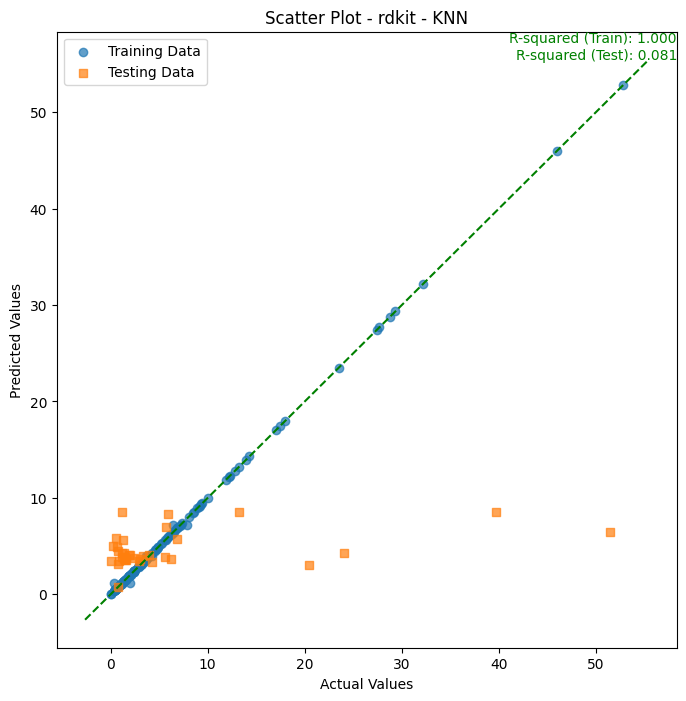

========== Feature Type: ECFP6 ==========
Model: KNN
Best Params: OrderedDict([('n_neighbors', 14), ('weights', 'distance')])
Results: {'cv_r2_mean': [0.002267851734488491], 'cv_r2_sd': [0.027359231614848677], 'r2_train': [0.9997128513286443], 'r2_test': [0.03453081943752956], 'cv_rmse_mean': [7.596821733330671], 'cv_rmse_sd': [2.255566518950298], 'rmse_train': [0.1365726835867916], 'rmse_test': [10.75124741593363]}




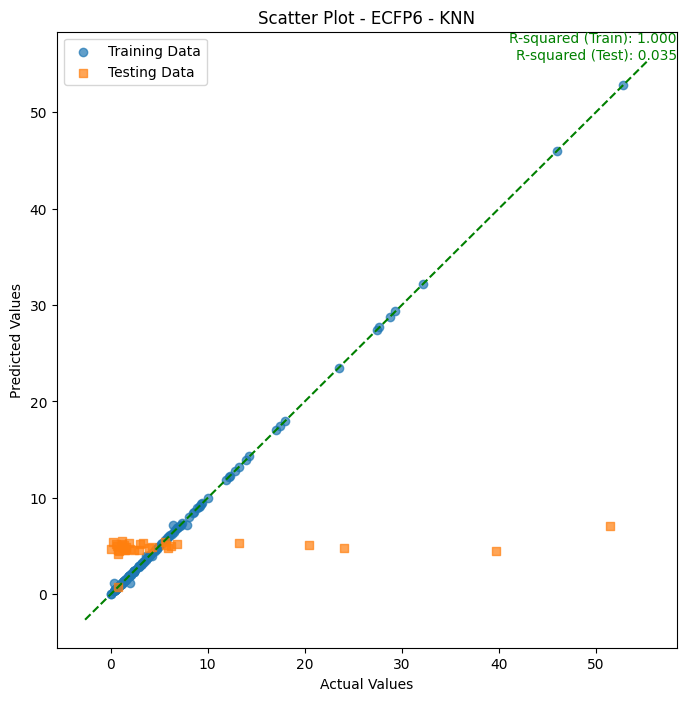

========== Feature Type: FCFP6 ==========
Model: KNN
Best Params: OrderedDict([('n_neighbors', 16), ('weights', 'distance')])
Results: {'cv_r2_mean': [0.013662330076017849], 'cv_r2_sd': [0.032938248346774876], 'r2_train': [0.9997128513286443], 'r2_test': [0.020175001786790214], 'cv_rmse_mean': [7.568791671611345], 'cv_rmse_sd': [2.315687752285337], 'rmse_train': [0.1365726835867916], 'rmse_test': [10.830884050262899]}




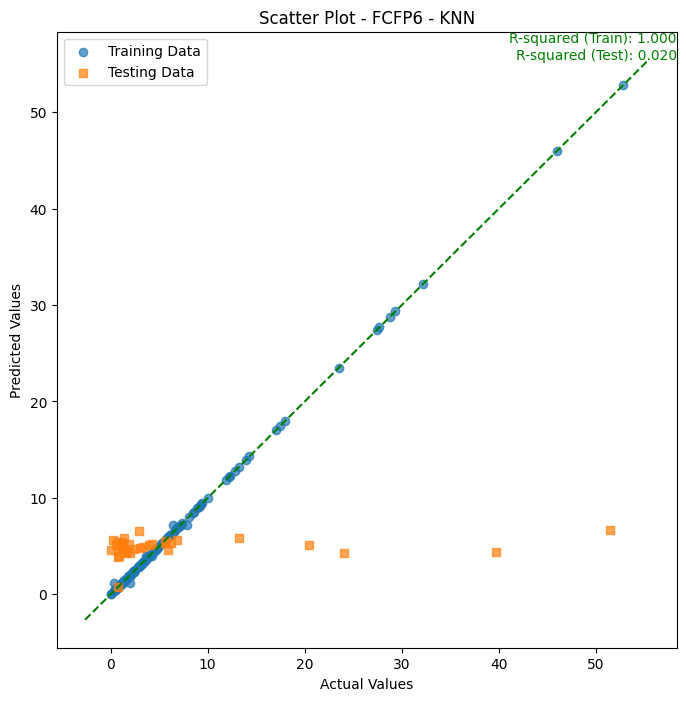

========== Feature Type: MACCS ==========
Model: KNN
Best Params: OrderedDict([('n_neighbors', 65), ('weights', 'distance')])
Results: {'cv_r2_mean': [0.0006631072403094684], 'cv_r2_sd': [0.016779660280365562], 'r2_train': [0.9984529259624381], 'r2_test': [0.06687836431939831], 'cv_rmse_mean': [7.645372147806535], 'cv_rmse_sd': [2.384847579861598], 'rmse_train': [0.31700490830287137], 'rmse_test': [10.569605511173902]}




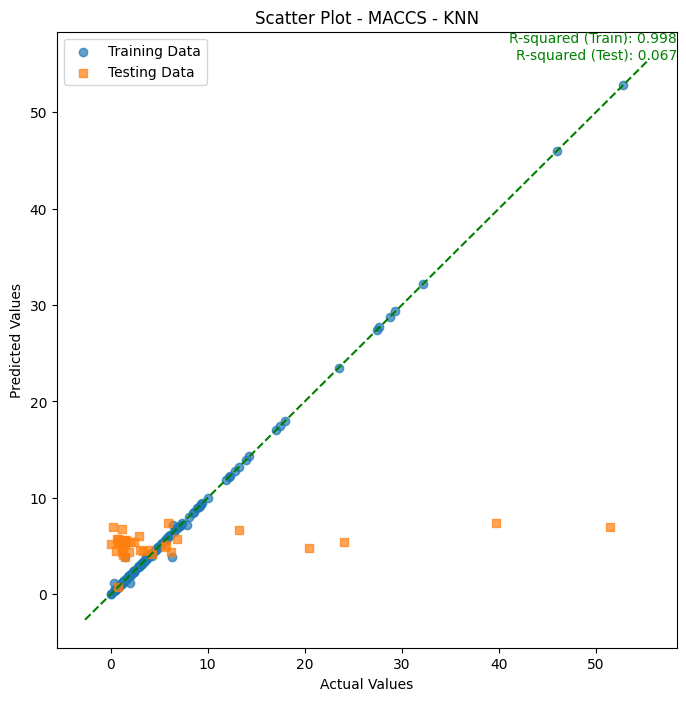

========== Feature Type: All_descrs ==========
Model: KNN
Best Params: OrderedDict([('n_neighbors', 18), ('weights', 'distance')])
Results: {'cv_r2_mean': [0.018082948174930346], 'cv_r2_sd': [0.041889126816757966], 'r2_train': [0.9997128513286424], 'r2_test': [0.009360646451085919], 'cv_rmse_mean': [7.605185108080522], 'cv_rmse_sd': [2.496360218553438], 'rmse_train': [0.13657268358725388], 'rmse_test': [10.890490414242509]}




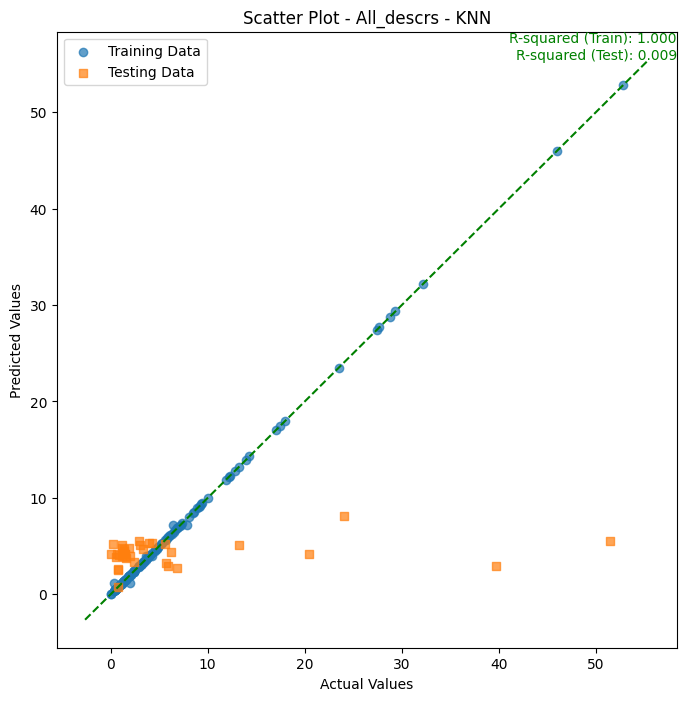

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Assuming you have a function `tuning_hyper` defined elsewhere in your code
# that returns the best model, best parameters, results, X_train, X_test, y_train, y_test

# Loop through feature types and models
for feature_type, X in zip(feature_types, [X_rdkit, X_ECFP6, X_FCFP6, X_MACCS, X_All_descrs]):
    print(f"========== Feature Type: {feature_type} ==========")

    for model_name, (model, _) in models.items():
        print(f"Model: {model_name}")

        # Ensure the same data is used for both hyperparameter tuning and evaluation
        best_model, best_params, results, X_train, X_test, y_train, y_test = tuning_hyper(X=X, y=y, model_name=model_name)

        # Print results of hyperparameter tuning
        print("Best Params:", best_params)
        print("Results:", results)
        print("\n")

        # Predictions on training and testing sets
        y_train_preds = best_model.predict(X_train)
        y_test_preds = best_model.predict(X_test)

        # Calculate R-squared value
        r2_train = r2_score(y_train, y_train_preds)
        r2_test = r2_score(y_test, y_test_preds)

        # Scatter plot for both training and testing datasets
        plt.figure(figsize=(8, 8))
        plt.scatter(y_train, y_train_preds, label="Training Data", marker='o', alpha=0.7)
        plt.scatter(y_test, y_test_preds, label="Testing Data", marker='s', alpha=0.7)

        # Add regression line y=x
        plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], linestyle='--', color='green')

        # Annotate with R-squared values on the right
        plt.text(plt.xlim()[1], plt.ylim()[1], f'R-squared (Train): {r2_train:.3f}\nR-squared (Test): {r2_test:.3f}', va='top', ha='right', fontsize=10, color='green')

        plt.title(f"Scatter Plot - {feature_type} - {model_name}")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")

        plt.legend()

        # Save the plot as TIFF with 320dpi resolution
        plt.savefig(f"scatter_plot_{feature_type}_{model_name}.tiff", dpi=320, format='tiff')

        # Display the plot
        plt.show()


# applicability domain function

========== Feature Type: rdkit, Model: KNN ==========
Training Applicability Domain: 100.00%
Test Applicability Domain: 100.00%
Training set chemicals exceeding AD area: []
Test set chemicals exceeding AD area: []


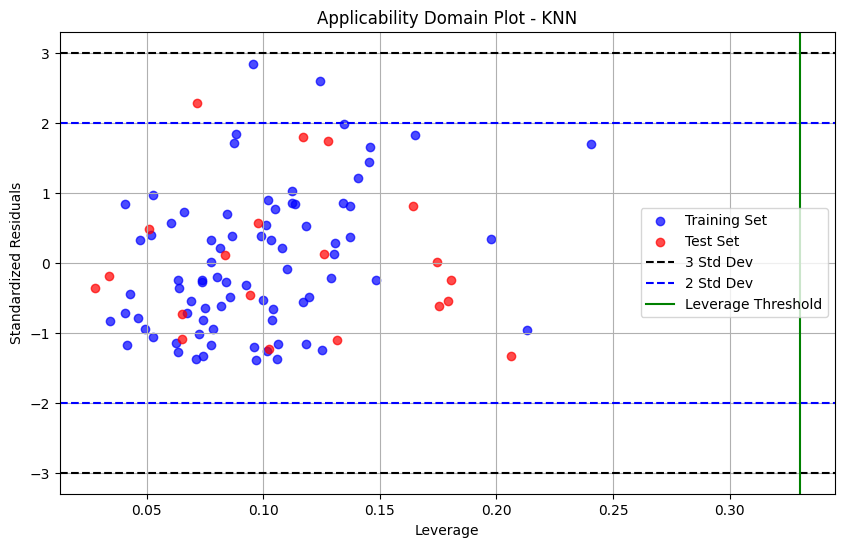

========== Feature Type: ECFP6, Model: KNN ==========
Training Applicability Domain: 100.00%
Test Applicability Domain: 100.00%
Training set chemicals exceeding AD area: []
Test set chemicals exceeding AD area: []


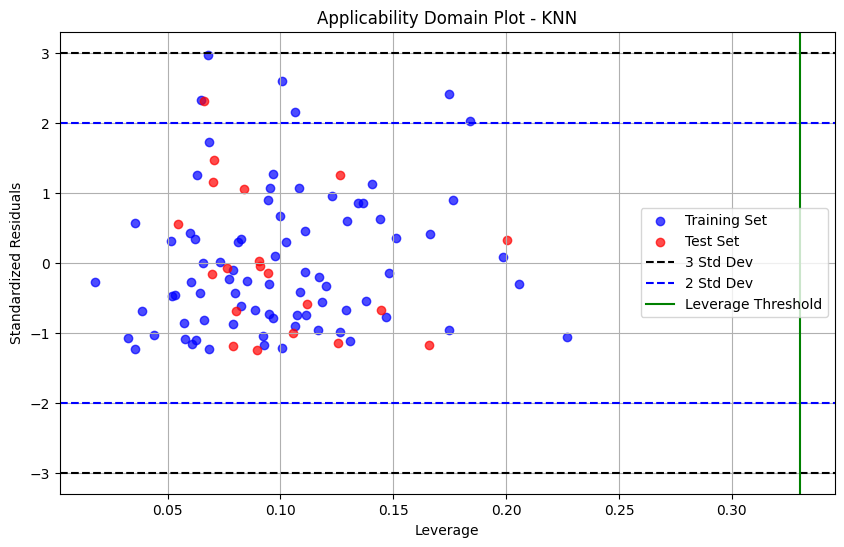

========== Feature Type: FCFP6, Model: KNN ==========
Training Applicability Domain: 98.75%
Test Applicability Domain: 95.00%
Training set chemicals exceeding AD area: [68]
Test set chemicals exceeding AD area: [7]


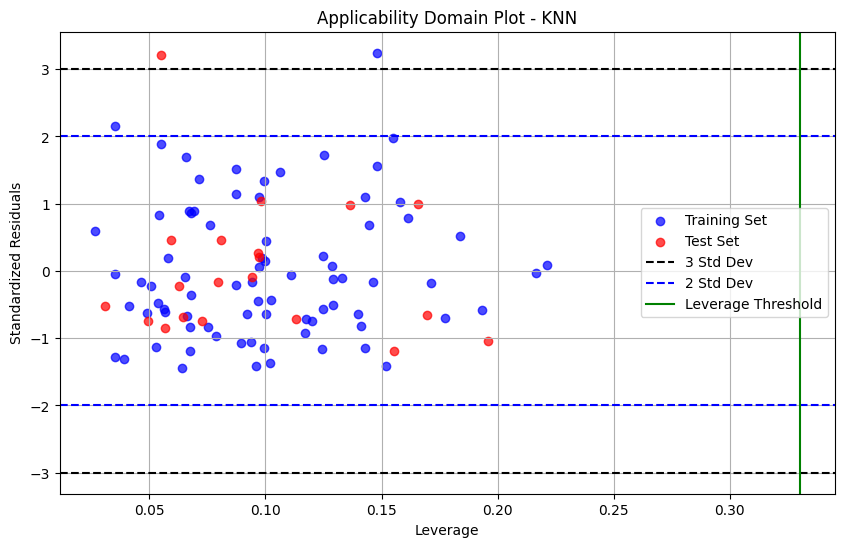

========== Feature Type: MACCS, Model: KNN ==========
Training Applicability Domain: 97.50%
Test Applicability Domain: 100.00%
Training set chemicals exceeding AD area: [69 73]
Test set chemicals exceeding AD area: []


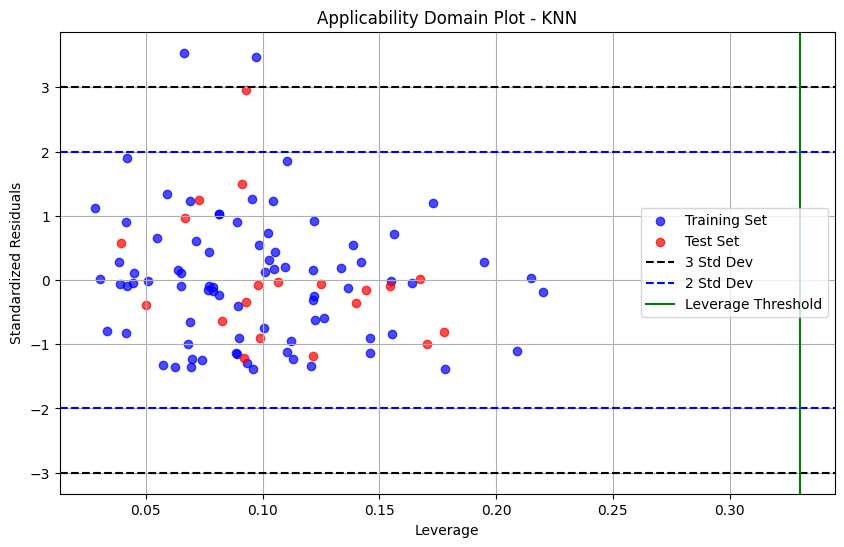

========== Feature Type: All_descrs, Model: KNN ==========
Training Applicability Domain: 100.00%
Test Applicability Domain: 95.00%
Training set chemicals exceeding AD area: []
Test set chemicals exceeding AD area: [9]


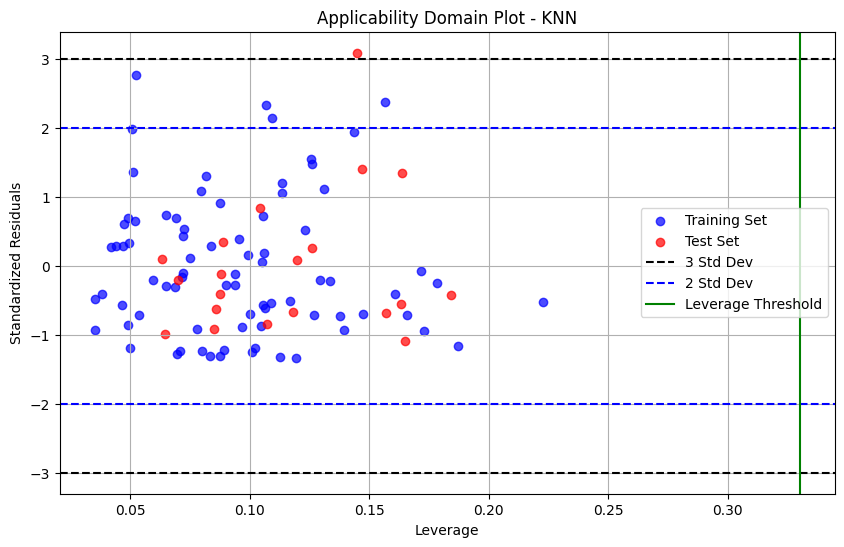

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import OLSInfluence

# ============================================
# Applicability Domain (AD) Function
# ============================================
def eval_ad(X_train, X_test, y_train, y_test, model):
    # Get model predictions for train and test sets
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Ensure y_train and y_test are 1D arrays if they aren't already
    y_train = y_train.reshape(-1) if y_train.ndim > 1 else y_train
    y_test = y_test.reshape(-1) if y_test.ndim > 1 else y_test
    y_pred_train = y_pred_train.reshape(-1)
    y_pred_test = y_pred_test.reshape(-1)

    # Calculate residuals and standardized residuals
    residual_train = np.abs(y_train - y_pred_train)
    residual_test = np.abs(y_test - y_pred_test)
    s_residual_train = (residual_train - np.mean(residual_train)) / np.std(residual_train)
    s_residual_test = (residual_test - np.mean(residual_test)) / np.std(residual_test)


    # Calculate leverage using OLS
    X_all = np.vstack((X_train, X_test))
    model_ols = OLS(np.ones(X_all.shape[0]), X_all).fit()
    influence = OLSInfluence(model_ols)
    leverage = influence.hat_matrix_diag

    # Define critical leverage threshold (h*)
    p = X_train.shape[1] + 1  # Number of features + intercept
    n = X_train.shape[0] + X_test.shape[0]  # Total number of compounds
    h_star = (3 * p) / n

    # Calculate Applicability Domain (AD) for train and test sets
    AD_train = 100 * np.sum((leverage[:X_train.shape[0]] < h_star) & (np.abs(s_residual_train) < 3)) / len(leverage[:X_train.shape[0]])
    AD_test = 100 * np.sum((leverage[X_train.shape[0]:] < h_star) & (np.abs(s_residual_test) < 3)) / len(leverage[X_train.shape[0]:])

    return AD_train, AD_test, s_residual_train, s_residual_test, leverage[:X_train.shape[0]], leverage[X_train.shape[0]:], h_star

# ============================================
# Model Training and AD Evaluation Loop
# ============================================
feature_types = ["rdkit", "ECFP6", "FCFP6", "MACCS", "All_descrs"]  # Add example feature types
X_rdkit, X_ECFP6, X_FCFP6, X_MACCS, X_All_descrs = [np.random.randn(100, 10) for _ in range(5)]  # Example feature matrices
y = np.random.randn(100)  # Example target vector
models = {"KNN": (model, None)}  # Define your models here, assuming 'model' is already defined

for feature_type, X in zip(feature_types, [X_rdkit, X_ECFP6, X_FCFP6, X_MACCS, X_All_descrs]):
    for model_name, (model, _) in models.items():
        print(f"========== Feature Type: {feature_type}, Model: {model_name} ==========")

        # Split data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

        # Train the model
        model.fit(X_train, y_train)

        # Evaluate Applicability Domain (AD)
        AD_train, AD_test, s_residual_train, s_residual_test, leverage_train, leverage_test, h_star = eval_ad(X_train, X_test, y_train, y_test, model)

        # Identify compounds exceeding the AD threshold
        train_exceed_AD = (leverage_train >= h_star) | (np.abs(s_residual_train) >= 3)
        test_exceed_AD = (leverage_test >= h_star) | (np.abs(s_residual_test) >= 3)

        # ============================================
        # Visualization - Applicability Domain Plot
        # ============================================
        plt.figure(figsize=(10, 6))

        # Scatter plot for training set
        plt.scatter(leverage_train, s_residual_train, c='blue', label='Training Set', alpha=0.7)

        # Scatter plot for test set
        plt.scatter(leverage_test, s_residual_test, c='red', label='Test Set', alpha=0.7)

        # Horizontal lines for residual bounds
        plt.axhline(y=3, color='black', linestyle='--', label='3 Std Dev')
        plt.axhline(y=-3, color='black', linestyle='--')
        plt.axhline(y=2, color='blue', linestyle='--', label='2 Std Dev')
        plt.axhline(y=-2, color='blue', linestyle='--')

        # Vertical line for leverage bound
        plt.axvline(x=h_star, color='green', linestyle='-', label='Leverage Threshold')

        plt.xlabel('Leverage')
        plt.ylabel('Standardized Residuals')
        plt.title(f'Applicability Domain Plot - {model_name}')
        plt.legend()
        plt.grid(True)

        # Save the plot as TIFF
        plt.savefig(f"AD_Plot_{feature_type}_{model_name}.tiff", format="tiff", dpi=300)

        # Print results
        print("Training Applicability Domain: {:.2f}%".format(AD_train))
        print("Test Applicability Domain: {:.2f}%".format(AD_test))
        print("Training set chemicals exceeding AD area:", np.where(train_exceed_AD)[0])
        print("Test set chemicals exceeding AD area:", np.where(test_exceed_AD)[0])

        # Show plot
        plt.show()
